In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys

sys.path.insert(0, '/nfs/privileged/isalazar/projects/ultrasound-image-formation/')
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from exploration.EMBC2024.cross_experiment.train import load_model as load_nair_model
from exploration.advtraining.ifsr001_nair_advTrain import load_model as load_nairAdv_model
from strohm_train import load_model as load_strohm_model
from wang_train import load_wang_model
from src.US_data import LoadData_phantomLIM_ATSmodel539, LoadDataPICMUS
from src.beamforming_utils import make_pixel_grid_from_pos
from utils import downsample_channel_data, compute_metrics
from src.beamforming_DAS import make_bimg_das1
from pytorch_msssim import MS_SSIM
from skimage.restoration import denoise_nl_means
import cv2

In [2]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def get_data_from_name(h5name):
    if h5name=='IS_L11-4v_data2_RF.h5':
        depths_ini_list = np.linspace(0, 80, 160)
        depth_ini = depths_ini_list[65]
        roi_ref = cv2.imread('data_2_frame_65.png', cv2.IMREAD_GRAYSCALE)

    elif h5name=='IS_L11-4v_data3_RF.h5':
        depths_ini_list = np.linspace(0, 80, 80)
        depth_ini = depths_ini_list[36]
        roi_ref = cv2.imread('data_3_frame_64.png', cv2.IMREAD_GRAYSCALE)

    elif h5name=='IS_L11-4v_data1_RF.h5':
        depths_ini_list = np.linspace(0, 80, 80)
        depth_ini = depths_ini_list[36]
        roi_ref = cv2.imread('data_1_frame_36.png', cv2.IMREAD_GRAYSCALE)
    else:
        raise NotImplementedError

    roi_ref = np.array(roi_ref)/255
    
    return depth_ini, roi_ref

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
this_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/'
basic_dataset_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data/'
h5_dataset_dir = f'{basic_dataset_dir}/verasonics'

# load model
epoch = 99
das_label = 'DAS'
# wang_label = 'wang_adv_eps0.008'
model_nair, _ = load_nair_model(model_dir=os.path.join(this_dir, "models", 'nair'),
                                epoch=epoch,
                                device=device)
model_strohm, _ = load_strohm_model(model_dir=os.path.join(this_dir, "models", 'strohm'),
                                    epoch=epoch,
                                    device=device)
model_wang, _, _, _, _ = load_wang_model(model_dir=os.path.join(this_dir, "models", 'wang'),
                                         epoch=epoch,
                                         num_downs=5,
                                         device=device)
model_nair.eval()
model_strohm.eval()
model_wang.eval()
print("")

Loading model 99...
Model 99 loaded.
Loading model 99...
Model 99 loaded.
Loading models 99...
Generator 99 loaded.
Discriminator 99 loaded.


In [4]:
h5name = 'IS_L11-4v_data2_RF.h5'

In [5]:
depth_ini, roi_ref = get_data_from_name(h5name)
P = LoadData_phantomLIM_ATSmodel539(h5_dir=h5_dataset_dir, h5_name=h5name)
max_value = np.max(np.abs(np.array([P.idata, P.qdata])))
P.idata = P.idata / max_value
P.qdata = P.qdata / max_value

laterals = np.linspace(P.phantom_xlims[0], P.phantom_xlims[-1], num=128)
depths = np.linspace(depth_ini, depth_ini+50, num=800) / 1000
P.grid_xlims = P.phantom_xlims
P.grid_zlims = np.array([depth_ini, depth_ini+50]) / 1000
# Downsample channel data
channel_data_phantom = downsample_channel_data(copy.deepcopy(P),
                                               laterals=laterals,
                                               depths=depths,
                                               device=device)
channel_data_phantom = channel_data_phantom / channel_data_phantom.abs().max()
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[-1], 128)
grid_full = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

das_phantom, _ = make_bimg_das1(copy.deepcopy(P), grid_full, device=device)
nair_phantom = model_nair(channel_data_phantom)
strohm_phantom = model_strohm(channel_data_phantom)
N, C, H, W = channel_data_phantom.size()
z = torch.randn(N, 1, H, W).to(device)
wang_phantom = model_wang(torch.cat((channel_data_phantom, z), dim=1))

output_in_bmode_format = lambda x: np.clip((x * 60 - 60).detach().cpu().numpy().squeeze(), a_min=-60, a_max=0)

das_phantom  = np.clip(das_phantom, a_min=-60, a_max=0)
nair_phantom = output_in_bmode_format(nair_phantom)
strohm_phantom = output_in_bmode_format(strohm_phantom)
wang_phantom = output_in_bmode_format(wang_phantom)
bmodes = {'DAS': das_phantom, 'NAIR': nair_phantom, 'STROHM': strohm_phantom, 'WANG': wang_phantom}

Dataset successfully loaded


In [6]:
extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
           P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]
opts = {"extent": extent_full, "origin": "upper"}

In [7]:
xctr, zctr = -9/1000, 50.25/1000
dist = np.sqrt((grid_full[:, :, 0] - xctr) ** 2 + (grid_full[:, :, 2] - zctr) ** 2)
r = 7.5/1000
r0 = r - 2/1000
r1 = r + 2/1000
r2 = np.sqrt(r0**2 + r1**2)
roi_cyst = dist <=r
roi_in = dist <= r0
roi_out = (r1 <= dist) * (dist <= r2)

Text(0.5, 0.98, 'IS_L11-4v_data2_RF.h5')

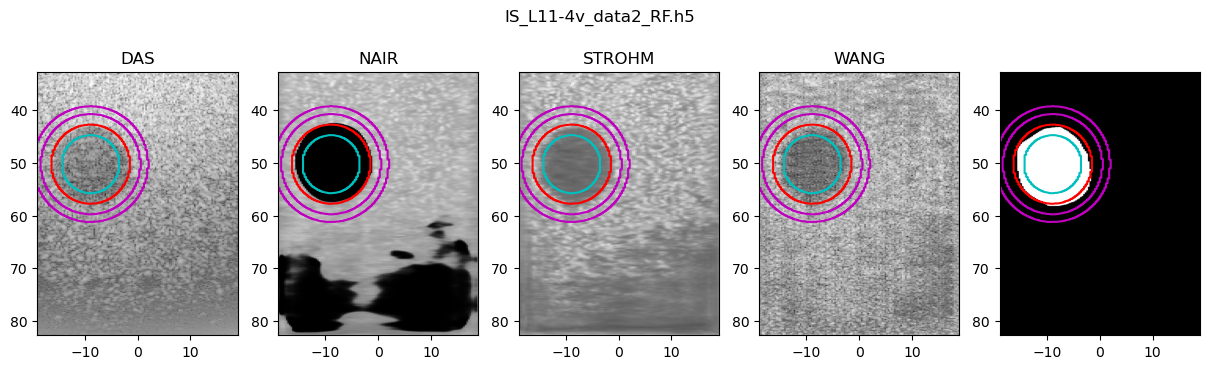

In [8]:
ncols = len(bmodes)
fig, ax = plt.subplots(nrows=1, ncols=ncols+1, figsize=(3 * (ncols+1), 4))
for counter, name in enumerate(bmodes):
    ax[counter].imshow(bmodes[name], cmap="gray", vmin=-60, vmax=0, **opts)
    # ax[counter].contourf(roi_in, )
    ax[counter].contour(roi_cyst, [0.5], colors="r", **opts)
    ax[counter].contour(roi_in, [0.5], colors="c", **opts)
    ax[counter].contour(roi_out, [0.5], colors="m", **opts)
    ax[counter].set_title(name)
ax[-1].imshow(roi_ref, cmap="gray", vmin=0, vmax=1, **opts)
ax[-1].contour(roi_cyst, [0.5], colors="r", **opts)
ax[-1].contour(roi_in, [0.5], colors="c", **opts)
ax[-1].contour(roi_out, [0.5], colors="m", **opts)
plt.suptitle('%s' % h5name)

##### Contrast

In [9]:
def contrast(img1, img2):
    return 20 * np.log10(img1.mean() / img2.mean())

In [10]:
for bmf in bmodes:
    bmode = bmodes[bmf]
    env = 10**(bmode/20)
    env_in = env[roi_in]
    env_out = env[roi_out]
    contrast_value = contrast(env_in, env_out)
    print(f'{bmf}: {contrast_value}')

DAS: -11.435072422027588
NAIR: -43.04244041442871
STROHM: -16.71860933303833
WANG: -15.195211172103882


##### IoU

In [11]:
# Initialize lists to store parameters and iou values
h_values = []
patch_size_values = []
patch_distance_values = []
threshold_values = []
name_values = []
iou_values = []

# Define parameter ranges
h_range = np.linspace(0.01, 0.21, 11)
patch_size_range = np.linspace(3, 15, 7)
patch_distance_range = np.linspace(3, 21, 10)
threshold_range = np.linspace(0.4, 0.7, 31)

# Iterate over parameter combinations
counter = 0
for h in h_range:
    for patch_size in patch_size_range:
        for patch_distance in patch_distance_range:
            for name in bmodes:
                bmode = bmodes[name]
                bmode_img = (bmode + 60) / 60
                smooth = denoise_nl_means(bmode_img,
                                            h=h,
                                            patch_size=int(patch_size),
                                            patch_distance=int(patch_distance),
                                            # sigma=sigma,
                                            preserve_range=True)
                print(f"({counter}/{11*7*10*4}) - hsname: {h5name}, h: {h}, patch_size: {patch_size}, patch_distance: {patch_distance}, bmf: {name}", end='')
                counter += 1
                for threshold in threshold_range:
                    print(".", end='')
                    roi_comp = smooth<threshold
                    iou = calculate_iou(roi_cyst, roi_comp)

                    # Append parameter values and iou to lists
                    h_values.append(h)
                    patch_size_values.append(patch_size)
                    patch_distance_values.append(patch_distance)
                    threshold_values.append(threshold)
                    name_values.append(name)
                    iou_values.append(iou)
                print(" ")

# Create DataFrame
data = {
    'h': h_values,
    'patch_size': patch_size_values,
    'patch_distance': patch_distance_values,
    'threshold': threshold_values,
    'name': name_values,
    'iou': iou_values
}

df = pd.DataFrame(data)
df.to_csv(f'grid_search_{h5name[:-4]}.csv', index=False)  # Set index=False to exclude row numbers


(0/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: DAS............................... 
(1/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: NAIR............................... 
(2/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: STROHM............................... 
(3/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 3.0, bmf: WANG............................... 
(4/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: DAS............................... 
(5/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: NAIR............................... 
(6/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distance: 5.0, bmf: STROHM............................... 
(7/3080) - hsname: IS_L11-4v_data2_RF.h5, h: 0.01, patch_size: 3.0, patch_distanc

In [14]:
df[df['iou'] == df['iou'].max()]

,h,patch_size,patch_distance,threshold,name,iou
40898,0.09,11.0,21.0,0.49,WANG,0.639744


In [15]:
df.groupby('name')['iou'].max()

name
DAS       0.149502
NAIR      0.278697
STROHM    0.363285
WANG      0.639744
Name: iou, dtype: float64

In [16]:
max_iou_index = df.groupby('name')['iou'].idxmax()
result_df = df.loc[max_iou_index]
result_df

,h,patch_size,patch_distance,threshold,name,iou
30646,0.07,9.0,17.0,0.58,DAS,0.149502
61783,0.15,3.0,19.0,0.40,NAIR,0.278697
30942,0.07,9.0,21.0,0.44,STROHM,0.363285
40898,0.09,11.0,21.0,0.49,WANG,0.639744


In [17]:
result_df['dice'] = 2*result_df['iou']/(1+result_df['iou'])

In [18]:
result_df

,h,patch_size,patch_distance,threshold,name,iou,dice
30646,0.07,9.0,17.0,0.58,DAS,0.149502,0.260116
61783,0.15,3.0,19.0,0.40,NAIR,0.278697,0.435908
30942,0.07,9.0,21.0,0.44,STROHM,0.363285,0.532955
40898,0.09,11.0,21.0,0.49,WANG,0.639744,0.780297
